In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from scipy.stats import chi2

In [2]:
data = pd.read_csv('2024-05-04_VHM.csv')[::-1].reset_index(drop=True)
data

,date,VND,demand,supply
0,2018-05-17,110.50,3741,14
1,2018-05-18,110.50,1836,0
2,2018-05-21,110.50,766,0
3,2018-05-22,118.20,558,2
4,2018-05-23,110.30,2625,785
...,...,...,...,...
1486,2024-04-24,40.60,4606,4520
1487,2024-04-25,40.70,3909,3437
1488,2024-04-26,40.80,4643,3973
1489,2024-02-05,41.15,5405,3139


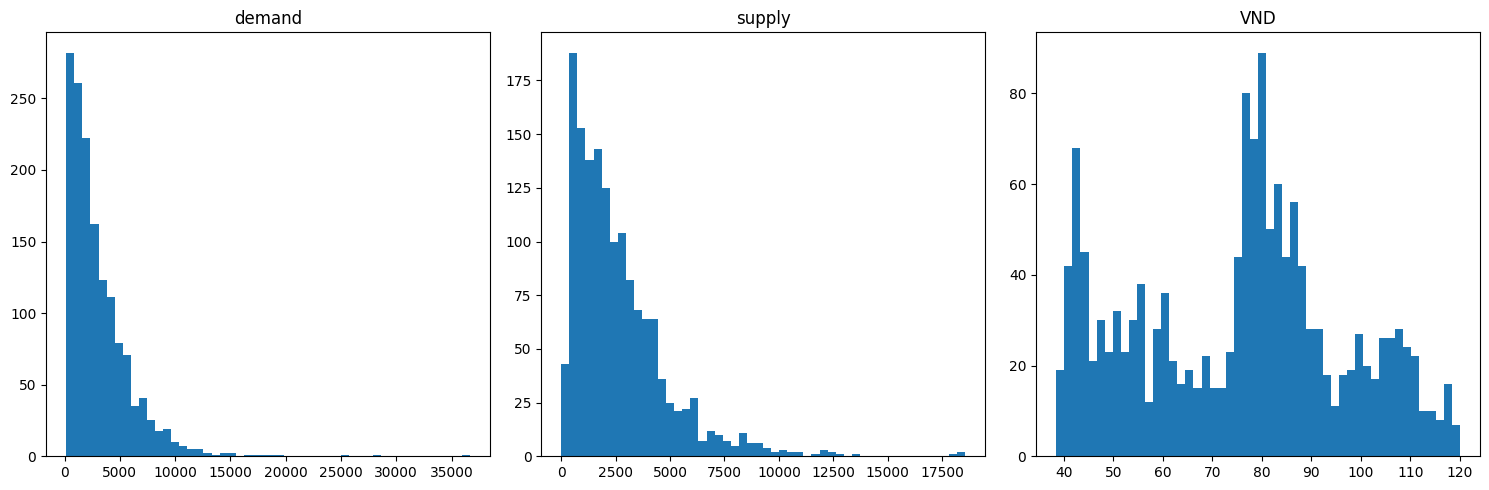

In [3]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
plt.hist(data['demand'], bins=50)
plt.title('demand')

plt.subplot(1,3,2)
plt.hist(data['supply'], bins=50)
plt.title('supply')

plt.subplot(1,3,3)
plt.hist(data['VND'], bins=50)
plt.title('VND')

plt.tight_layout()

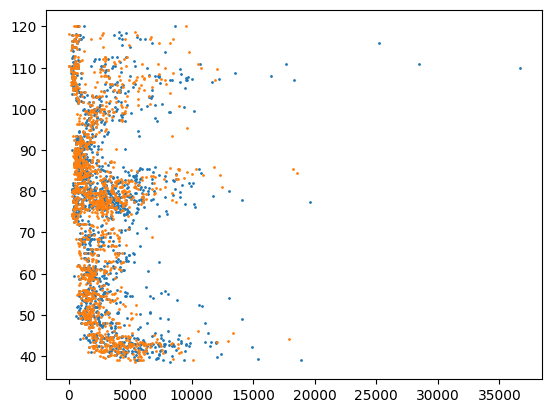

In [4]:
plt.scatter(data['demand'], data['VND'], label='demand', s=1)
plt.scatter(data['supply'], data['VND'], label='supply', s=1)

In [82]:
def check_outlier(data, low_th, high_th):
   Q3 = np.percentile(data, high_th, method='midpoint')
   Q1 = np.percentile(data, low_th, method='midpoint')
   IQR = Q3 - Q1
   lower = Q1 - 1.5*IQR
   upper = Q3 + 1.5*IQR
   mask = (data > upper) | (data < lower)
   return mask

def resample(data, total_size=500000):
    result = []
    while len(result) < total_size:
        indices = np.random.randint(low=0, high=len(data), size=len(data))
        sample = data[indices]
        result.append(np.mean(sample))
    mask = check_outlier(result, 10, 90)
    result = np.delete(result, np.where(mask))
    return result


demand = resample(data['demand'].values)
supply = resample(data['supply'].values)
vnd = resample(data['VND'].values)

In [83]:
len(demand), len(vnd)

(500000, 500000)

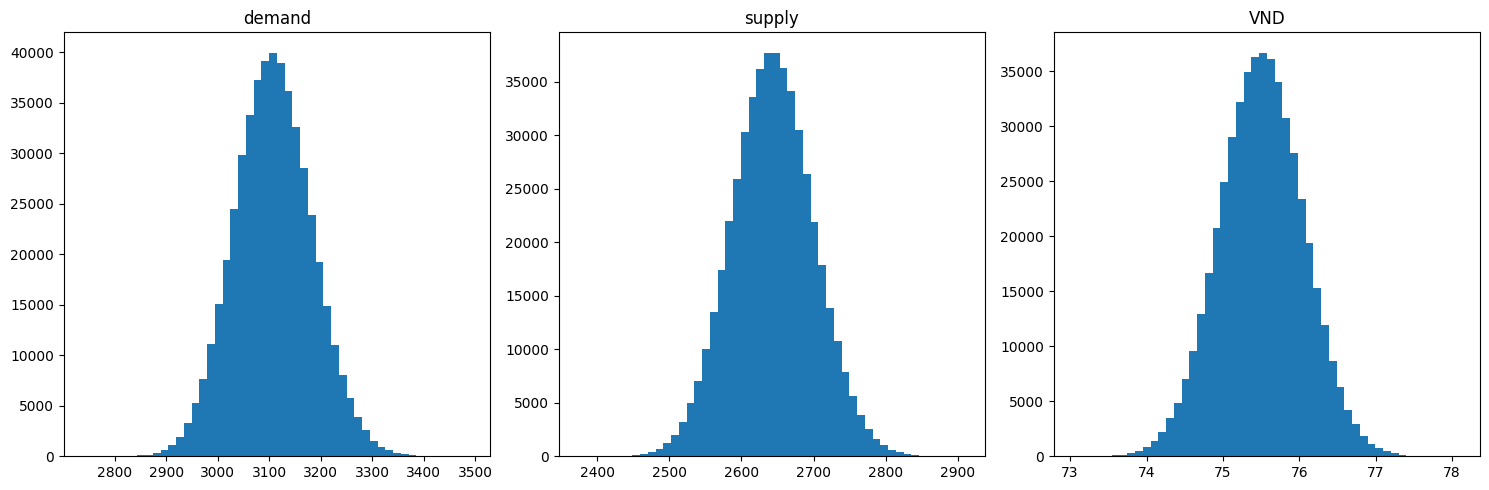

In [84]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
plt.hist(demand, bins=50)
plt.title('demand')

plt.subplot(1,3,2)
plt.hist(supply, bins=50)
plt.title('supply')

plt.subplot(1,3,3)
plt.hist(vnd, bins=50)
plt.title('VND')

plt.tight_layout()

In [85]:
x_sm = np.linspace(min(min(demand), min(supply))-1000, max(max(demand), max(supply))+1000, 1000)

z_d = np.polyfit(demand, vnd, 1)
y_hat_d = z_d[1] + z_d[0]*x_sm
y_hat_d = np.round(y_hat_d, 2)

# procesing demand
z_s = np.polyfit(supply, vnd, 1)
y_hat_s = z_s[1] + z_s[0]*x_sm
y_hat_s = np.round(y_hat_s, 2)

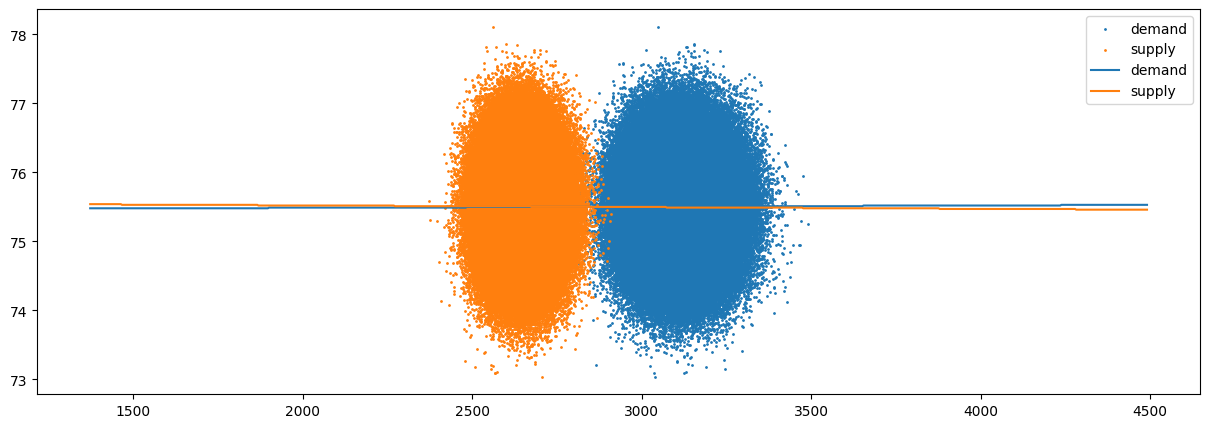

In [86]:
plt.figure(figsize=(15, 5))


plt.scatter(demand, vnd, label='demand', s=1)
plt.scatter(supply, vnd, label='supply', s=1)

plt.plot(x_sm, y_hat_d, label='demand')
plt.plot(x_sm, y_hat_s, label='supply')

plt.legend()

In [87]:
index = np.where(y_hat_d == y_hat_s)[0]
mid_point = np.mean(y_hat_d[index])
print(mid_point)

75.5


In [88]:
def estimation_sigma(data):
    n = len(data)
    S = data.std()
    up = ( (n-1)*S**2 ) / ( chi2.isf(1-0.05/2, n-1) )
    down = ( (n-1)*S**2 ) / ( chi2.isf(0.05/2, n-1) )
    return np.sqrt(down), np.sqrt(up)

In [89]:
std = estimation_sigma(data['VND'])[0]
print(std)

20.38904019667969


In [90]:
line_mid = [mid_point for _ in range(len(data))]
line_sell = [mid_point - std for _ in range(len(data))]

In [91]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=data['VND'], 
                        mode='lines',
                        name='Stock'))

fig.add_trace(go.Scatter(y=line_mid,
                    mode='lines',
                    name='Balance'))

fig.add_trace(go.Scatter(y=line_sell,
                    mode='lines',
                    name='Sell'))
fig.show()

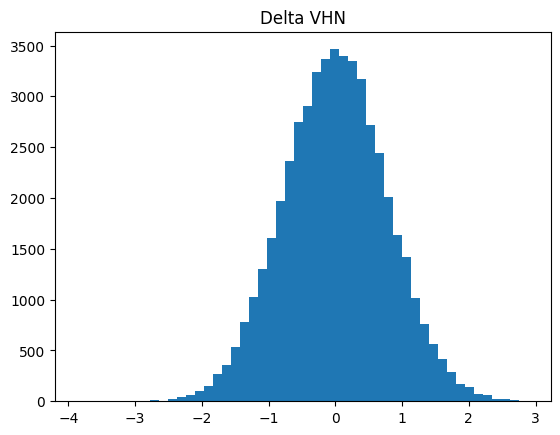

In [15]:
delta = [vnd[i+1] - vnd[i] for i in range(len(vnd) - 1)]

plt.hist(delta, bins=50)
plt.title('Delta VHN')
plt.show()

# VHM

Balance: 75.46

Sigma low: 20.39

SELL: 55

In [73]:
def resample_mul(data, total_size=500000):
    results = [[] for _ in data]
    for _ in range(total_size):
        indices = np.random.randint(low=0, high=len(data[0]), size=len(data[0]))
        for i, elem in enumerate(data):
            sample = elem[indices].mean()
            results[i].append(sample)
    for i, result in enumerate(results):
        mask = check_outlier(result, 5, 95)
        results[i] = np.delete(results[i], np.where(mask))
    return results

In [74]:
resample_data = resample_mul(data=[data['demand'].values, data['supply'].values, data['VND'].values])

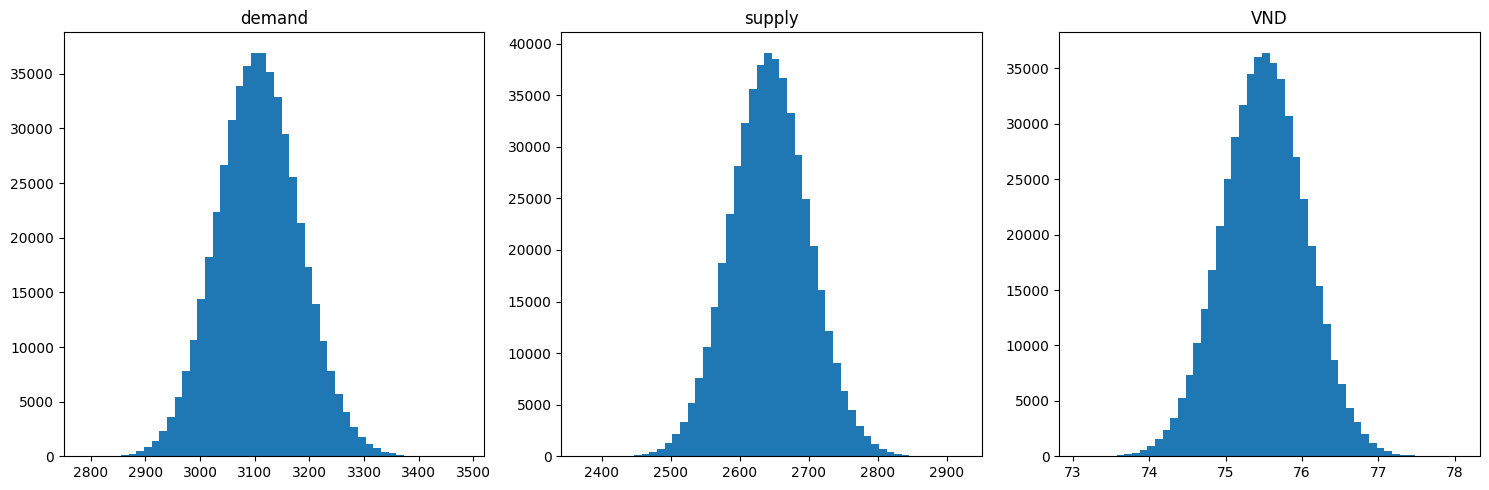

In [75]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
plt.hist(resample_data[0], bins=50)
plt.title('demand')

plt.subplot(1,3,2)
plt.hist(resample_data[1], bins=50)
plt.title('supply')

plt.subplot(1,3,3)
plt.hist(resample_data[2], bins=50)
plt.title('VND')

plt.tight_layout()

In [76]:
x_sm = np.linspace(min(min(resample_data[0]), min(resample_data[1]))-2000, max(max(resample_data[0]), max(resample_data[1]))+1000, 1000)

z_d = np.polyfit(resample_data[0], resample_data[2], 1)
y_hat_d = z_d[1] + z_d[0]*x_sm
y_hat_d = np.round(y_hat_d, 2)

# procesing demand
z_s = np.polyfit(resample_data[1], resample_data[2], 1)
y_hat_s = z_s[1] + z_s[0]*x_sm
y_hat_s = np.round(y_hat_s, 2)

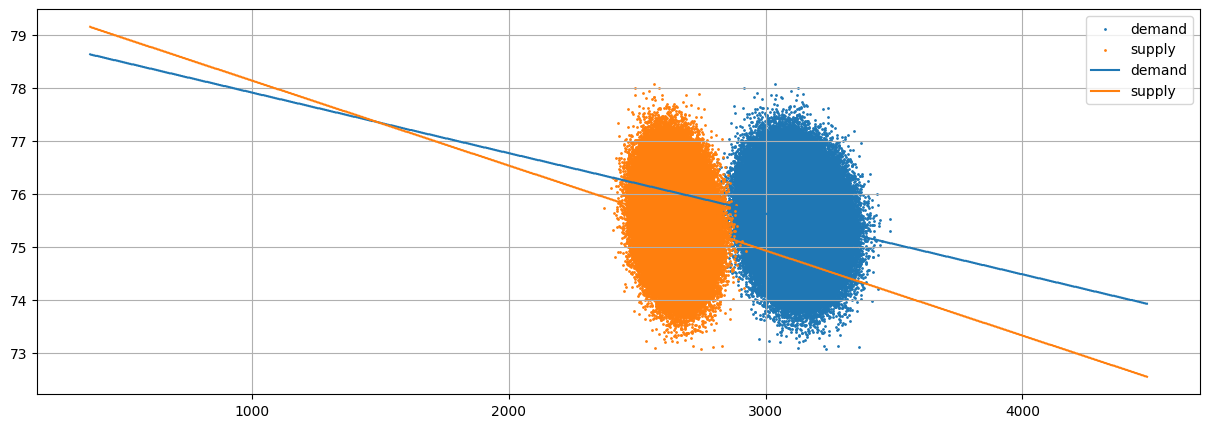

In [77]:
plt.figure(figsize=(15, 5))


plt.scatter(resample_data[0], resample_data[2], label='demand', s=1)
plt.scatter(resample_data[1], resample_data[2], label='supply', s=1)

plt.plot(x_sm, y_hat_d, label='demand')
plt.plot(x_sm, y_hat_s, label='supply')

plt.grid()
plt.legend()

In [80]:
index = np.where(y_hat_d == y_hat_s)[0]
mid_point = np.mean(y_hat_d[index])
print(mid_point)

77.36000000000001


In [81]:
77.56 - std

57.170959803320315